# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

# Observations

* The top part of the max temperature bell curve is closer to 20 latitude as opposed to the expected equator (0).

* A lot of the cloudiness values seem to be rounded by seeing a lot of values making horizontal lines.  I believe this is due to us not really having a way to measure this and meteoroligist just rounding out their estimates.

* 40 latitude has 4 cities with a 30 mph wind speed or greater.  Only one other latitude has 1 city at 30 mph.  As expected a majority of the cities have less than 10 mph.

* The linear regression model of humidity shows us that the average humidity from the south pole to the north pole does not vary much at all.  This comes as the biggest surprise, however, cloudiness and wind speed averages don't vary between the south pole and north pole either.

In [2]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import json
from scipy.stats import linregress

# Import API key
from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [2]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
len(cities)

591

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it's being processed (with the city number and city name).


In [3]:
# Function to ask the user what unit of measurement for Temperature they would like to use.
def Unitof_Measure():
    
    # Dictionary for Temperatures. 
    measurement_dict = {
        "name": ["standard", "metric", "imperial"],
        "valid_responses": ["k", "c", "f"],
        "temperature": ["Kelvin", "Celcius", "Fahrenheit"],
        "wind_speed_names": ["meter/sec", "meter/sec", "miles/hour"],
        "wind_speed": ["mps", "mps", "mph"]
    }

    # Set boolean variable to False.
    valid_meas = False
    
    # As long as our boolean variable is still False the following will be repeated.
    while valid_meas == False:
        
        # Ask for user input.
        temp_unit = str(input("What unit of measure for Temperature would you like to pull (Kelvin, Celcius or Fahrenheit)?  "))
        # Saving the lower case version of the first character that was submitted.
        first_char = temp_unit[0].lower()
        
        
        # A for loop to go through the dictionary list "valid_responses".
        for index, valid in enumerate(measurement_dict["valid_responses"]):
            
            # If the first character saved from user input matches the current valid_response in the list.
            if first_char == valid:

                # Assigning unit_name to the same index in the dictionary, but of the "name" list.
                unit_name = measurement_dict["name"][index]
                # Assigning temp_unit to the same index in the dictionary, but of the "temperature" list.
                temp_unit = measurement_dict["temperature"][index]
                # Assigning wind_speed_unit to the same index in the dictionary, but of the "wind_speed" list.
                wind_speed_unit = measurement_dict["wind_speed"][index]
                

                # Changing boolean variable to true since a match was found.
                valid_meas = True
                # Break out of for loop since there is no longer a reason to continue.
                break
                
        
        # Before finishing the while loop check if boolean still False.
        # If so, then print an invalid message to the user before they are prompted again.
        if valid_meas == False:
            print()
            print("You did not select a valid unit of measure.")
        
        
    # Returning two variables.
    # str_meas is the name needed for the API url format.
    # temp_unit is the name people are accustomed to using.
    return unit_name, temp_unit, wind_speed_unit, valid.capitalize()

In [4]:
# Creating a list of the three elements that the Unitof_Measure function returns.
unit_info = Unitof_Measure()

# Printing what the user has selected
print()
print(f"You selected {unit_info[0]} Units / {unit_info[1]} ({unit_info[3]}) Temperatures / ({unit_info[2]}) Wind Speeds")


What unit of measure for Temperature would you like to pull (Kelvin, Celcius or Fahrenheit)?  fahr

You selected imperial Units / Fahrenheit (F) Temperatures / (mph) Wind Speeds


In [5]:
### This will take about 10 minutes to run.  To skip this step in future openings skip the next two 'In'
### and read the data from the already created CSV.

# Empty dictionary that the API pull can append to.
city_dict = {
    "city": [],
    "cloudiness": [],
    "country": [],
    "date": [],
    "humidity": [],
    "lat": [],
    "lng": [],
    "max_temp": [],
    "wind_speed": []}

# Blank prints to make space for readability and then 
# announcement of the Unit of Measurement for Temperature.
print()
temp_unit = unit_info[0]
print()
print(f"You selected {unit_info[0]} Units / {unit_info[1]} ({unit_info[3]}) Temperatures / ({unit_info[2]}) Wind Speeds")
print()
print()
print(f"Beginning Data Retrieval")
print("-----------------------------")


## Edit this to change list of cities to loop through.
## cities is created by random latitude and random longitude values.
city_list = cities

# Empty list to append cities not found in the API.
cities_notlisted = []

#Count of cities
countof_list = len(city_list)

# A loop so that each city can go to the correct URL.  
# Using enumerate to know what index each city is at.
for index, city in enumerate(city_list):
    
    # The url that will be used with .json() with a city variable, an api_key variable
    # and a temperatureunit of measure variable.
    url = "http://api.openweathermap.org/data/2.5/weather?q=" + city + "&appid=" + weather_api_key + "&units=" + temp_unit
    request = requests.get(url).json()
    
    # Checking for a 404 code.  If the city doesn't exist in the API continue to next city.
    if request["cod"] == "404":
        # Print the city was not found and the name of the city.
        print(f"City not found: {city},  Skipping...")
        # Append to the cities_notlisted list.
        cities_notlisted.append(city)
        continue
    
    # Printing the city number we are on, the total number of cities, and the city name.
    print(f"Processing record {index + 1} of {countof_list} | {city}")
    
    # Appending each field of the dictionary from the API.
    city_dict["city"].append(request["name"]) 
    city_dict["cloudiness"].append(request["clouds"]["all"])
    city_dict["country"].append(request["sys"]["country"])
    city_dict["date"].append(request["dt"])
    city_dict["humidity"].append(request["main"]["humidity"])
    city_dict["lat"].append(request["coord"]["lat"])
    city_dict["lng"].append(request["coord"]["lon"])
    city_dict["max_temp"].append(request["main"]["temp_max"])
    city_dict["wind_speed"].append(request["wind"]["speed"])
 
    # Pausing code for 1 second after each pull.
    time.sleep(1)

# Creating a new DataFrame from the dictionary that was just created from the API pull loop.
data_raw = pd.DataFrame(city_dict)
# Output this DataFrame to csv, so that we don't have to scrape the API every time we want to reopen Jupyter.
data_raw.to_csv("output_data/cities.csv", index=True, index_label="city_id")

# Blank prints to make space for readability and then announcement of cities not listed.
print()
print()
print()
print()
print("The list of cities not found in the API is called 'cities_notlisted.'")
print(f"The following are the cities in that list:")
print()

# Print the list of all the cities that were not found in the API.
for index, city in enumerate(cities_notlisted):
    print(f"{index + 1}: {city}")



You selected imperial Units / Fahrenheit (F) Temperatures / (mph) Wind Speeds


Beginning Data Retrieval
-----------------------------
City not found: vaitupu,  Skipping...
Processing record 2 of 591 | new norfolk
Processing record 3 of 591 | sao filipe
Processing record 4 of 591 | liverpool
Processing record 5 of 591 | bredasdorp
Processing record 6 of 591 | hami
Processing record 7 of 591 | nagorsk
Processing record 8 of 591 | kahului
Processing record 9 of 591 | rikitea
City not found: saleaula,  Skipping...
Processing record 11 of 591 | cape town
Processing record 12 of 591 | cabo san lucas
City not found: nizhneyansk,  Skipping...
Processing record 14 of 591 | tiksi
City not found: samusu,  Skipping...
Processing record 16 of 591 | longyearbyen
Processing record 17 of 591 | bluff
Processing record 18 of 591 | grande prairie
Processing record 19 of 591 | port blair
Processing record 20 of 591 | ilulissat
Processing record 21 of 591 | torbay
City not found: marcona,  Skipping...
P

Processing record 203 of 591 | geraldton
Processing record 204 of 591 | pizhma
Processing record 205 of 591 | anloga
Processing record 206 of 591 | hirara
Processing record 207 of 591 | chico
Processing record 208 of 591 | ostrovnoy
Processing record 209 of 591 | lixourion
Processing record 210 of 591 | kununurra
Processing record 211 of 591 | linjiang
Processing record 212 of 591 | flin flon
Processing record 213 of 591 | paysandu
Processing record 214 of 591 | khani
Processing record 215 of 591 | castro
Processing record 216 of 591 | mantena
Processing record 217 of 591 | coquimbo
Processing record 218 of 591 | lerwick
Processing record 219 of 591 | colares
Processing record 220 of 591 | boguchar
Processing record 221 of 591 | sao jose da coroa grande
Processing record 222 of 591 | ola
Processing record 223 of 591 | narsaq
Processing record 224 of 591 | faanui
Processing record 225 of 591 | carauari
Processing record 226 of 591 | sokoto
Processing record 227 of 591 | chuy
Processing 

Processing record 408 of 591 | prince rupert
Processing record 409 of 591 | keuruu
Processing record 410 of 591 | chifeng
Processing record 411 of 591 | ohara
Processing record 412 of 591 | sorland
Processing record 413 of 591 | sanming
Processing record 414 of 591 | lata
Processing record 415 of 591 | podyuga
Processing record 416 of 591 | zhezkazgan
Processing record 417 of 591 | itapirapua
City not found: lolua,  Skipping...
Processing record 419 of 591 | lorengau
Processing record 420 of 591 | datong
Processing record 421 of 591 | zalesovo
City not found: kadykchan,  Skipping...
Processing record 423 of 591 | jensen beach
City not found: sorvag,  Skipping...
Processing record 425 of 591 | kasongo-lunda
Processing record 426 of 591 | mount gambier
Processing record 427 of 591 | kourou
Processing record 428 of 591 | komsomolskiy
Processing record 429 of 591 | union
Processing record 430 of 591 | oktyabrskiy
Processing record 431 of 591 | mbuji-mayi
Processing record 432 of 591 | weat

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [9]:
# Creating a DataFrame based on the csv file output.
# This is handy if our notebook has been reopened and we don't want to pull from the API again.
data_raw = pd.read_csv("output_data/cities.csv")
data_raw = data_raw.set_index("city_id")
data_raw.index.name = None
data_raw

# Renaming columns in DataFrame
data_raw = data_raw.rename(columns={
    "city": "City",
    "cloudiness": "Cloudiness",
    "country": "Country",
    "date": "Date",
    "humidity": "Humidity",
    "lat": "Latitude",
    "lng": "Longitude",
    "max_temp": "Max Temp",
    "wind_speed": "Wind Speed"
})
data_raw.head()

,City,Cloudiness,Country,Date,Humidity,Latitude,Longitude,Max Temp,Wind Speed
0,New Norfolk,67,AU,1619134730,61,-42.7826,147.0587,53.01,4.00
1,São Filipe,54,CV,1619134731,72,14.8961,-24.4956,72.61,9.80
2,Liverpool,9,GB,1619134702,54,53.4106,-2.9779,51.80,6.91
3,Bredasdorp,1,ZA,1619134734,93,-34.5322,20.0403,51.80,2.30
4,Kumul,99,CN,1619134537,31,42.8000,93.4500,46.02,6.20


In [7]:
data_raw.describe()

,city_id,Cloudiness,Date,Humidity,Latitude,Longitude,Max Temp,Wind Speed
count,533.000000,533.000000,5.330000e+02,533.000000,533.000000,533.000000,533.000000,533.000000
mean,266.000000,54.714822,1.619135e+09,70.300188,20.581824,19.337369,59.518518,8.434916
std,154.008117,37.137437,2.460978e+02,22.246144,33.184543,88.769302,18.968965,5.786644
min,0.000000,0.000000,1.619134e+09,6.000000,-54.800000,-175.200000,3.020000,0.070000
25%,133.000000,20.000000,1.619135e+09,58.000000,-6.216700,-58.075600,44.600000,4.120000
50%,266.000000,68.000000,1.619135e+09,77.000000,26.124700,25.200000,62.110000,7.000000
75%,399.000000,90.000000,1.619135e+09,87.000000,47.423500,98.333200,77.000000,11.300000
max,532.000000,100.000000,1.619136e+09,100.000000,78.218600,179.316700,91.800000,41.470000


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

In [8]:
def Scatterplots_def(x_field, y_field, PNGname):
    
    #Creating a list of the gathered x_field and y_field
    field_list = [x_field, y_field]
    #Creating a list of the two columns that are known to need a unit of measure assigned to them.
    df_column_changes = ["Max Temp", "Wind Speed"]
    
    # A bit redundant, but preserving our original x_field and y_field variables before
    # morphing the xlabel and ylabel in the later for loops.
    xlabel = x_field
    ylabel = y_field
    
    # Assigning the entire series of the column names given the appropriate axis.
    x_axis = data_raw[x_field]
    y_axis = data_raw[y_field]

    # Using the time import.  %x displays the current date.
    date = time.strftime("%x")

    # A scatter plot based on our x_axis and y_axis variables.
    plt.scatter(x_axis, y_axis, marker="o", facecolors="blue", edgecolors="black")
    
    
    ## Nested for loop to check for Max Temp and Wind Speed inside of our df_column_changes list.
    ## If the fields entered to be plotted are either of them the appropriate unit is attached to the end.
    for index1, field in enumerate(field_list):
        for index2, column in enumerate(df_column_changes):
            if column == field:
                if index1 == 0:
                    if index2 == 0:
                        xlabel = column + " (" + unit_info[3] + ")"
                        break
                    elif index2 == 1:
                        xlabel = column + " (" + unit_info[2] + ")"
                        break
                if index1 == 1:
                    if index2 == 0:
                        ylabel = column + " (" + unit_info[3] + ")"
                        break
                    elif index2 == 1:
                        ylabel = column + " (" + unit_info[2] + ")"
                        break                   

    # Assigning the title string.
    title_str = ("City " + xlabel + " vs. " + ylabel + " (" + date + ")")

    # Set the plot title, and x and y axis labels.
    plt.title(title_str)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    
    #Seting the limit of the x axis to being minus 2 of the minimum Weight, and plus 2 of the maximum Weight.
    plt.xlim(min(x_axis)-  2, max(x_axis) + 2)
    #Seting the limit of the y axis to being minus 3 of the minimum Tumor_Vol, and plus 3 of the maximum Tumor_Vol.
    plt.ylim(min(y_axis) - 3, max(y_axis) + 3)
    
    #Saving the plot as a .png file in the 'output_data' folder with the filename declared in the 'PNGname' variable.
    plt.savefig("output_data/" + PNGname + ".png")
    plt.show()

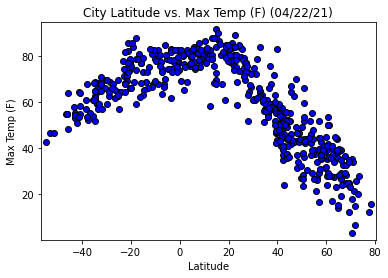

The Maximum Temperature where negative Latitude is closer to the south pole,
and positive Latitude is closer to the north pole.

This image is showing a curve with a peak close to 0 Latitude.
Latitude 0 is the equator, and the farther away the colder the temperature becomes.


In [9]:
# Setting two variables as the name of the column in the data_raw DataFrame.
x_axis = "Latitude"
y_axis = "Max Temp"

# Calling our Scatterplots_def function and telling it to print the image as "fig1"
Scatterplots_def(x_axis, y_axis, PNGname="fig1")

# Printing what can be seen from the graph.
print("The Maximum Temperature where negative Latitude is closer to the south pole,")
print("and positive Latitude is closer to the north pole.")
print()
print("This image is showing a curve with a peak close to 0 Latitude.")
print("Latitude 0 is the equator, and the farther away the colder the temperature becomes.")

## Latitude vs. Humidity Plot

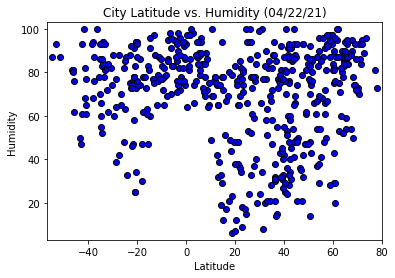

The Humidity where negative Latitude is closer to the south pole,
and positive Latitude is closer to the north pole.

High Humidity can be pretty much anywhere north and south.
The lower Humidity tends to be a bit closer to the equator, but only on the north side.


In [10]:
# Setting two variables as the name of the column in the data_raw DataFrame.
x_axis = "Latitude"
y_axis = "Humidity"

# Calling our Scatterplots_def function and telling it to print the image as "fig2"
Scatterplots_def(x_axis, y_axis, PNGname="fig2")

# Printing what can be seen from the graph.
print("The Humidity where negative Latitude is closer to the south pole,")
print("and positive Latitude is closer to the north pole.")
print()
print("High Humidity can be pretty much anywhere north and south.")
print("The lower Humidity tends to be a bit closer to the equator, but only on the north side.")

## Latitude vs. Cloudiness Plot

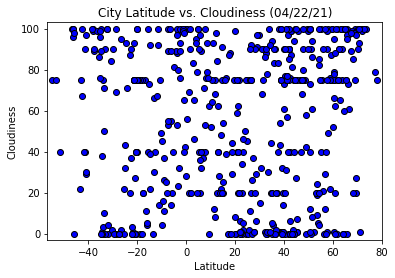

The percent Cloudiness where negative Latitude is closer to the south pole,
and positive Latitude is closer to the north pole.

North, south and close to the equator can have low and high Cloudiness.
There are a lot of density at some rounded numbers, ie:  0, 20, 40, 75, and 100.
This is due to human rounding by meteoroligist.


In [11]:
# Setting two variables as the name of the column in the data_raw DataFrame.
x_axis = "Latitude"
y_axis = "Cloudiness"

# Calling our Scatterplots_def function and telling it to print the image as "fig3"
Scatterplots_def(x_axis, y_axis, PNGname="fig3")

# Printing what can be seen from the graph.
print("The percent Cloudiness where negative Latitude is closer to the south pole,")
print("and positive Latitude is closer to the north pole.")
print()
print("North, south and close to the equator can have low and high Cloudiness.")
print("There are a lot of density at some rounded numbers, ie:  0, 20, 40, 75, and 100.")
print("This is due to human rounding by meteoroligist.")

## Latitude vs. Wind Speed Plot

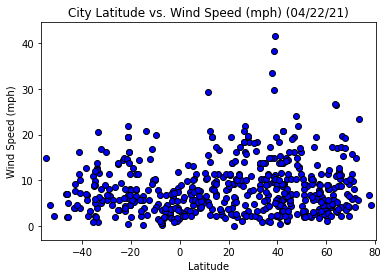

The Wind Speed where negative Latitude is closer to the south pole,
and positive Latitude is closer to the north pole.

There appears to be no correlation between north and south when it comes to Wind Speed.


In [12]:
# Setting two variables as the name of the column in the data_raw DataFrame.
x_axis = "Latitude"
y_axis = "Wind Speed"

# Calling our Scatterplots_def function and telling it to print the image as "fig4"
Scatterplots_def(x_axis, y_axis, PNGname="fig4")

# Printing what can be seen from the graph.
print("The Wind Speed where negative Latitude is closer to the south pole,")
print("and positive Latitude is closer to the north pole.")
print()
print("There appears to be no correlation between north and south when it comes to Wind Speed.")

## Linear Regression

In [13]:
## Creating a new DataFrame of only cities in the Northern Hemisphere.
north_hem = data_raw.loc[(data_raw["Latitude"] >= 0), :]
## Creating a new DataFrame of only cities in the Southern Hemisphere.
south_hem = data_raw.loc[(data_raw["Latitude"] < 0), :]

def Scatterplots_north_def(x_field, y_field):
    
    #Creating a list of the gathered x_field and y_field
    field_list = [x_field, y_field]
    #Creating a list of the two columns that are known to need a unit of measure assigned to them.
    df_column_changes = ["Max Temp", "Wind Speed"]
    
    # A bit redundant, but preserving our original x_field and y_field variables before
    # morphing the xlabel and ylabel in the later for loops.
    xlabel = x_field
    ylabel = y_field
    
    # Assigning the entire series of the column names given the appropriate axis.
    x_axis = north_hem[x_field]
    y_axis = north_hem[y_field]
    
    # Setting the limit of the x axis to be 10% bigger on each side.
    lim_x = min(x_axis) - ((max(x_axis) - min(x_axis)) / 10), max(x_axis) + ((max(x_axis) - min(x_axis)) / 10)
    # Setting the limit of the y axis to be 20% bigger on each side.  More space for the annotote.
    lim_y = min(y_axis) - ((max(y_axis) - min(y_axis)) / 5), max(y_axis) + ((max(y_axis) - min(y_axis)) / 5)
    
    # Annotote is where on the graph the regression line equation is written.
    annotote_x = ((min(x_axis) + max(x_axis))/2)
    annotote_y = min(y_axis) - (max(y_axis) - min(y_axis)) / 7

    
    # Using the time import.  %x displays the current date.
    date = time.strftime("%x")
    
    # Using the imported linregress function with the x_axis and y_axis parameters.
    # Gives us the slope, slope, intercept, rvalue, pvalue, stderr.
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
    
    # Creating the equation of the regression line.
    regress_values = x_axis * slope + intercept
    # Creating the string of the equation of the regression line.
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    
    # Scatter plot based on our x_axis variable and y_axis variable.
    plt.scatter(x_axis,y_axis, marker="o", facecolors="blue", edgecolors="black")
    # Plotting the regression line.
    plt.plot(x_axis,regress_values,"g-")
    # Plotting the equation of the regression line.
    plt.annotate(line_eq,(annotote_x, annotote_y), fontsize=15, color="red")

    
    ## Nested for loop to check for Max Temp and Wind Speed inside of our df_column_changes list.
    ## If the fields entered to be plotted are either of them the appropriate unit is attached to the end.    
    for index1, field in enumerate(field_list):
        for index2, column in enumerate(df_column_changes):
            if column == field:
                if index1 == 0:
                    if index2 == 0:
                        xlabel = column + " (" + unit_info[3] + ")"
                        break
                    elif index2 == 1:
                        xlabel = column + " (" + unit_info[2] + ")"
                        break
                if index1 == 1:
                    if index2 == 0:
                        ylabel = column + " (" + unit_info[3] + ")"
                        break
                    elif index2 == 1:
                        ylabel = column + " (" + unit_info[2] + ")"
                        break                   

    # Assigning the title string.
    title_str = ("City " + xlabel + " vs. " + ylabel + " (" + date + ")")

    # Set the plot title, and x and y axis labels.
    plt.title(title_str)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    #Seting the limit of the x axis to being minus 2 of the minimum Weight, and plus 2 of the maximum Weight.
    plt.xlim(lim_x)
    #Seting the limit of the y axis to being minus 3 of the minimum Tumor_Vol, and plus 3 of the maximum Tumor_Vol.
    plt.ylim(lim_y)

    #Printing the rvalue.
    print(f"The r-value is {rvalue}")
    
    plt.show()
    
def Scatterplots_south_def(x_field, y_field):
    
    #Creating a list of the gathered x_field and y_field
    field_list = [x_field, y_field]
    #Creating a list of the two columns that are known to need a unit of measure assigned to them.
    df_column_changes = ["Max Temp", "Wind Speed"]
    
    # A bit redundant, but preserving our original x_field and y_field variables before
    # morphing the xlabel and ylabel in the later for loops.
    xlabel = x_field
    ylabel = y_field
    
    # Assigning the entire series of the column names given the appropriate axis.
    x_axis = south_hem[x_field]
    y_axis = south_hem[y_field]

    
    # Setting the limit of the x axis to be 10% bigger on each side.
    lim_x = min(x_axis) - ((max(x_axis) - min(x_axis)) / 10), max(x_axis) + ((max(x_axis) - min(x_axis)) / 10)
    # Setting the limit of the y axis to be 20% bigger on each side.  More space for the annotote.
    lim_y = min(y_axis) - ((max(y_axis) - min(y_axis)) / 5), max(y_axis) + ((max(y_axis) - min(y_axis)) / 5)
    
    # Annotote is where on the graph the regression line equation is written.
    annotote_x = ((min(x_axis) + max(x_axis))/2)
    annotote_y = min(y_axis) - (max(y_axis) - min(y_axis)) / 7

    
    # Using the time import.  %x displays the current date.    
    date = time.strftime("%x")
    
    # Using the imported linregress function with the x_axis and y_axis parameters.
    # Gives us the slope, slope, intercept, rvalue, pvalue, stderr.
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
    
    # Creating the equation of the regression line.
    regress_values = x_axis * slope + intercept
    # Creating the string of the equation of the regression line.
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    
    # Scatter plot based on our x_axis variable and y_axis variable.
    plt.scatter(x_axis,y_axis, marker="o", facecolors="blue", edgecolors="black")
    # Plotting the regression line.
    plt.plot(x_axis,regress_values,"g-")
    # Plotting the equation of the regression line.
    plt.annotate(line_eq,(annotote_x, annotote_y), fontsize=15, color="red")

    
    ## Nested for loop to check for Max Temp and Wind Speed inside of our df_column_changes list.
    ## If the fields entered to be plotted are either of them the appropriate unit is attached to the end.
    for index1, field in enumerate(field_list):
        for index2, column in enumerate(df_column_changes):
            if column == field:
                if index1 == 0:
                    if index2 == 0:
                        xlabel = column + " (" + unit_info[3] + ")"
                        break
                    elif index2 == 1:
                        xlabel = column + " (" + unit_info[2] + ")"
                        break
                if index1 == 1:
                    if index2 == 0:
                        ylabel = column + " (" + unit_info[3] + ")"
                        break
                    elif index2 == 1:
                        ylabel = column + " (" + unit_info[2] + ")"
                        break                   

    # Assigning the title string.
    title_str = ("City " + xlabel + " vs. " + ylabel + " (" + date + ")")

    # Set the plot title, and x and y axis labels.
    plt.title(title_str)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    #Seting the limit of the x axis to being minus 2 of the minimum Weight, and plus 2 of the maximum Weight.
    plt.xlim(lim_x)
    #Seting the limit of the y axis to being minus 3 of the minimum Tumor_Vol, and plus 3 of the maximum Tumor_Vol.
    plt.ylim(lim_y)

    #Printing the rvalue.
    print(f"The r-value is {rvalue}")
    
    plt.show()

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-value is -0.8951430687793034


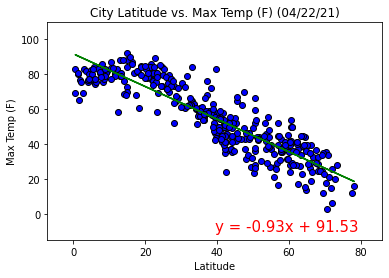

The Max Temperature in the Northern Hemisphere shows a steady decline,
because as the x axis gets bigger it's approaching the north pull.


In [14]:
# Setting two variables as the name of the column in the north_hem DataFrame.
x_axis = "Latitude"
y_axis = "Max Temp"

# Calling our Scatterplots_north_def function
Scatterplots_north_def(x_axis, y_axis)

# Printing what can be seen from the graph.
print("The Max Temperature in the Northern Hemisphere shows a steady decline,")
print("because as the x axis gets bigger it's approaching the north pull.")

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-value is 0.7673596577145562


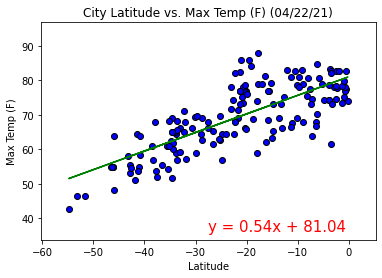

The Max Temperature in the Southern Hemisphere shows a steady incline,
because as the x axis gets bigger it's approaching the equator.


In [15]:
# Setting two variables as the name of the column in the south_hem DataFrame.
x_axis = "Latitude"
y_axis = "Max Temp"

# Calling our Scatterplots_south_def function
Scatterplots_south_def(x_axis, y_axis)

# Printing what can be seen from the graph.
print("The Max Temperature in the Southern Hemisphere shows a steady incline,")
print("because as the x axis gets bigger it's approaching the equator.")

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-value is 0.1315124036006289


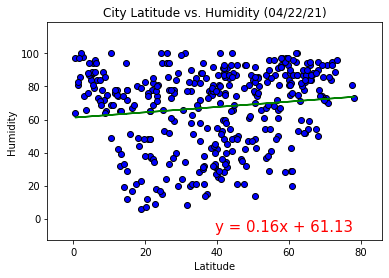

The Humidity in the Northern Hemisphere shows a small incline as you get closer to the north pole.
This graph looks to have a pretty even spread,
but there is a large density above the regression line between 50-70 Latittude.


In [16]:
# Setting two variables as the name of the column in the north_hem DataFrame.
x_axis = "Latitude"
y_axis = "Humidity"

# Calling our Scatterplots_north_def function
Scatterplots_north_def(x_axis, y_axis)

# Printing what can be seen from the graph.
print("The Humidity in the Northern Hemisphere shows a small incline as you get closer to the north pole.")
print("This graph looks to have a pretty even spread,")
print("but there is a large density above the regression line between 50-70 Latittude.")

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-value is 0.1330330489521847


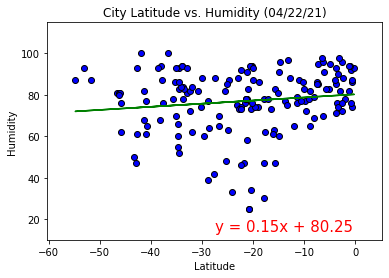

The Humidity in the Southern Hemisphere shows to remain rather constant.
There are a few really low values around -20 Latitude that get evened out by
a higher density just above the regression line.
Which also leads to a y-intercept of 20 higher than the Northern Hemisphere.


In [17]:
# Setting two variables as the name of the column in the south_hem DataFrame.
x_axis = "Latitude"
y_axis = "Humidity"

# Calling our Scatterplots_south_def function
Scatterplots_south_def(x_axis, y_axis)

# Printing what can be seen from the graph.
print("The Humidity in the Southern Hemisphere shows to remain rather constant.")
print("There are a few really low values around -20 Latitude that get evened out by")
print("a higher density just above the regression line.")
print("Which also leads to a y-intercept of 20 higher than the Northern Hemisphere.")

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-value is 0.17885589709670174


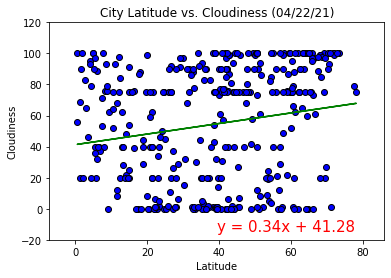

The Cloudiness in the Northern Hemisphere shows to remain rather constant with a y-intercept of 53.57.


In [18]:
# Setting two variables as the name of the column in the north_hem DataFrame.
x_axis = "Latitude"
y_axis = "Cloudiness"

# Calling our Scatterplots_north_def function
Scatterplots_north_def(x_axis, y_axis)

# Printing what can be seen from the graph.
print("The Cloudiness in the Northern Hemisphere shows to remain rather constant with a y-intercept of 53.57.")

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-value is 0.011803320269033673


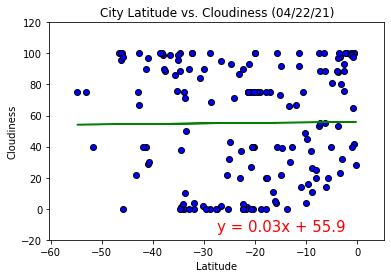

The Cloudiness in the Southern Hemisphere shows to remain rather constant with a y-intercept of 53.72.
This essentially the same y-intercept with a slope of just barely negative.
Also because this graph is heading to the equator.


In [19]:
# Setting two variables as the name of the column in the south_hem DataFrame.
x_axis = "Latitude"
y_axis = "Cloudiness"

# Calling our Scatterplots_south_def function
Scatterplots_south_def(x_axis, y_axis)

# Printing what can be seen from the graph.
print("The Cloudiness in the Southern Hemisphere shows to remain rather constant with a y-intercept of 53.72.")
print("This essentially the same y-intercept with a slope of just barely negative.")
print("Also because this graph is heading to the equator.")

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-value is 0.0030317596655891513


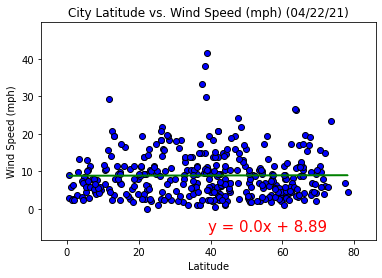

The Cloudiness in the Northern Hemisphere has a slope of ZERO!.
The regression line stays at 9.06.  Most of the records are below, and also influenced by 0 wind cities.
There is no upper bound, so there are fewer points above the line.


In [20]:
# Setting two variables as the name of the column in the north_hem DataFrame.
x_axis = "Latitude"
y_axis = "Wind Speed"

# Calling our Scatterplots_north_def function
Scatterplots_north_def(x_axis, y_axis)

# Printing what can be seen from the graph.
print("The Cloudiness in the Northern Hemisphere has a slope of ZERO!.")
print("The regression line stays at 9.06.  Most of the records are below, and also influenced by 0 wind cities.")
print("There is no upper bound, so there are fewer points above the line.")

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-value is -0.17351867032256654


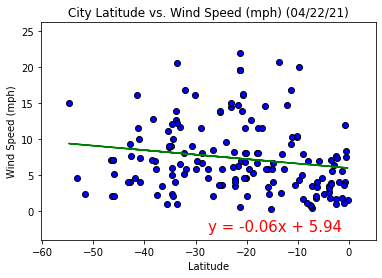

The Cloudiness in the Southern Hemisphere has barely any slope at -0.01.
The y-intercept of 7.23 is almost 2 mph less than the North.
The biggest density is below the regression line near the equator.


In [21]:
# Setting two variables as the name of the column in the south_hem DataFrame.
x_axis = "Latitude"
y_axis = "Wind Speed"

# Calling our Scatterplots_south_def function
Scatterplots_south_def(x_axis, y_axis)

# Printing what can be seen from the graph.
print("The Cloudiness in the Southern Hemisphere has barely any slope at -0.01.")
print("The y-intercept of 7.23 is almost 2 mph less than the North.")
print("The biggest density is below the regression line near the equator.")